In [688]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt 
import scipy.optimize
from scipy.stats import chi2, kstwobign, norm
from mpmath import mp

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [689]:
n = 100
columns = [i for i in range(0, 9+1)]
index = ["*.x*"]
data_df = pd.DataFrame(columns=columns, index = pd.Index(index))
data_df.loc["*.x*"] = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
data_df

,0,1,2,3,4,5,6,7,8,9
*.x*,5,8,6,12,14,18,11,6,13,7


# а) $$H_0: \xi \ \text{\textasciitilde} \ p(x) = 0.1\{k\} \in [0, 9] \cap \Z$$
# $$H_1: \overline{H_0}$$
# $$\alpha = 0.05$$

## Проверка гипотезы с помощью критерия ${\chi}^2$ (Пирсона) для простой гипотезы

In [690]:
alpha = 0.05

p_np_df = pd.DataFrame(columns=columns, index=pd.Index(["p_i", "np_i"]))
p_np_df.loc["p_i", :] = np.array([0.1 for _ in range(0, 9+1)])
p_np_df.loc["np_i", :] = np.array([0.1*n for i in range(0, 9+1)])
p_np_df

,0,1,2,3,4,5,6,7,8,9
p_i,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
np_i,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


#### $n \ge 50;\ n p_i \ge 5\ \ \forall i \in [0, 9] \cap \Z \Rightarrow$ можно применить критерий Пирсона без объединения колонн

## $$\widetilde{\Delta} = \displaystyle\sum_{i=1}^n \frac{(n p_i - m_i)^2}{n p_i}$$

In [691]:
p = 1/10 # Для равномерного распределения для дискретных значений
delta = 0
for i in range(0, 9+1): delta += (n*p - data_df.loc["*.x*", i])**2 / (n*p)
print(f"\u0303\u0394 = {delta}")

̃Δ = 16.4


# $$p\_value = P(\Delta \ge \widetilde{\Delta}|H_0) = \displaystyle\int_{\widetilde{\Delta}}^{+\infty} q(t)dt$$
# $q(t) = (\chi^2(k-1))'$

In [692]:
sf = chi2.sf(delta, 10-1)
print(f"p-value = {sf}")

p-value = 0.058984030544419454


### p-value $> \alpha \Rightarrow$ Нет оснований отвергуть $H_0$

## Проверка гипотезы с помощью критерия Колмогорова для простой гипотезы

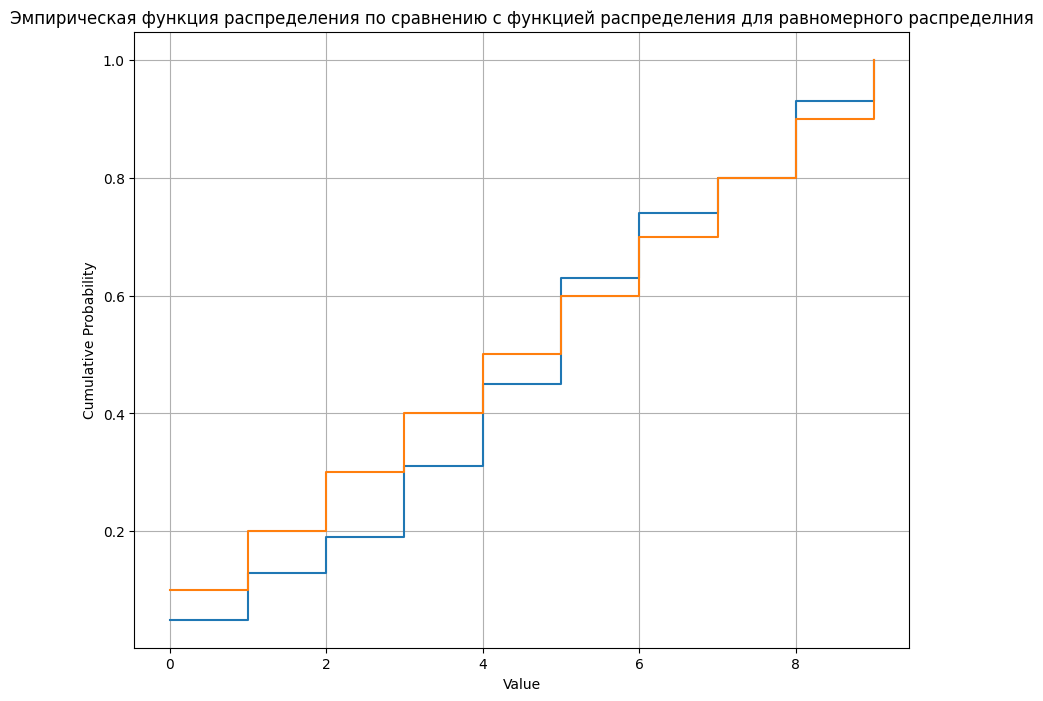

In [693]:
p_even = [i/10 for i in range(1, 10+1)]
p_empirical = [data_df.loc["*.x*", 0]/n]
for i in range(1, 9+1):
    p_empirical.append(p_empirical[i-1] + data_df.loc["*.x*", i]/n)


# Plotting
plt.step(columns, p_empirical, where='post')
plt.step(columns, p_even, where="post")
plt.title('Эмпирическая функция распределения по сравнению с функцией распределения для равномерного распределния')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

In [694]:
print(f"tp_even = \t{p_even}")
print(f"p_empirical = \t{p_empirical}")

tp_even = 	[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
p_empirical = 	[0.05, 0.13, 0.19, 0.31, 0.45, 0.63, 0.74, 0.8, 0.93, 1.0]


# $$\widetilde{\Delta} = \sqrt{n}\displaystyle\sup\limits_{x \in \R}|\widetilde{F}(x) - F(x)|$$

Здесь $\widetilde{F}(x)$ - эмпирическая функция распределения

In [695]:
delta = 0
delta = max(abs(p_even[0] - 0), abs(p_even[0] - p_empirical[0]))
for i in range(1, 9+1):
    delta = max(delta, abs(p_even[i] - p_empirical[i-1]), abs(p_even[i] - p_empirical[i]))
delta *= math.sqrt(n)
print(f"\u0303\u0394 = {delta}")

̃Δ = 2.1


## $$p\_value = P(\Delta \ge \widetilde{\Delta}|H_0) = \displaystyle\int_{\widetilde{\Delta}}^{+\infty} q(t)dt$$
# $q(t) = (K(t))'$

In [696]:
kolmogorov_dist = kstwobign
sf_value = kolmogorov_dist.sf(delta)
print(f"p-value = {sf_value}")

p-value = 0.0002954967204631142


### p-value $\le \alpha \Rightarrow$ отвергаем $H_0$

# б) $$H_0: \xi \ \text{\textasciitilde} N(\theta_1, {\theta_2}^2)\ \ \ (p(x) = \frac{1}{\theta_2\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\theta_1}{\theta_2})^2})$$
# $$H_1: \overline{H_0}$$
# $$\alpha = 0.05$$

## Проверка гипотезы с помощью критерия ${\chi}^2$ (Пирсона) для сложной гипотезы

In [697]:
columns = ["(-inf, 1)", "[1, 2)", "[2, 3)", "[3, 4)", "[4, 5)", "[5, 6)", "[6, 7)", "[7, 8)", "[8, 9)", "[9, +inf)"]
index = pd.Index(["m_i"])
data_df = pd.DataFrame(columns=columns, index=index)
data_df.loc["m_i", :] = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
data_df

,"(-inf, 1)","[1, 2)","[2, 3)","[3, 4)","[4, 5)","[5, 6)","[6, 7)","[7, 8)","[8, 9)","[9, +inf)"
m_i,5,8,6,12,14,18,11,6,13,7


## $$p_0 = \displaystyle\int_{-\infty}^{1} \frac{1}{\theta_2\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\theta_1}{\theta_2})^2}dx$$
## $$p_m = \displaystyle\int_{m}^{m+1} \frac{1}{\theta_2\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\theta_1}{\theta_2})^2}dx, \ m \in [1, 8] \cap \N$$
## $$p_9 = \displaystyle\int_{9}^{+\infty} \frac{1}{\theta_2\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\theta_1}{\theta_2})^2}dx$$

### Замена переменных:

## $$\widetilde{x} = \frac{m - \theta_1}{\theta_2 \sqrt{2}};\ \ \ \ erf(x) = \frac{2}{\sqrt{\pi}}\displaystyle\int_{0}^{x}e^{-t^2}dt;\ \ \ \ \widetilde{erf}(x) = \frac{erf(x) + 1}{2}$$

### После замены вероятности выглядят в виде:

## $$p_0 = \widetilde{erf}(\frac{1-\theta_1}{\theta_2 \sqrt{2}})$$
## $$p_m = \widetilde{erf}(\frac{m-\theta_1+1}{\theta_2 \sqrt{2}}) - \widetilde{erf}(\frac{m-\theta_1}{\theta_2 \sqrt{2}}) , \ m \in [1, 8] \cap \N $$
## $$p_9 = 1 - \widetilde{erf}(\frac{9-\theta_1}{\theta_2 \sqrt{2}})$$

### Из-за требуемой точности вычислений была необходимость использовать библиотеку mpmath и считать интегралы в исходном виде, не пользуясь выведенными формулами

In [698]:
def p_m(m: int, theta_1: float, theta_2: float) -> float:
    mp.dps = 50  # Set decimal places
    if m == 0:
        # return _erf(1-theta_1/(theta_2*math.sqrt(2)))
        # return _erf(1-theta_1/(math.sqrt(theta_2*2)))
        # return float(mp.quad(lambda x: mp.exp(-x**2), [-100, (1-theta_1)/(theta_2*math.sqrt(2))]))
        return mp.quad(lambda x: (1/(theta_2*math.sqrt(math.pi*2)))*mp.exp((-1/2)*(((x-theta_1)/(theta_2)))**2), [-1000, 1])
    elif 1 <= m <= 8:
        # return _erf((m - theta_1 + 1)/(theta_2*math.sqrt(2))) - _erf((m - theta_1)/(theta_2*math.sqrt(2)))
        # return _erf((m - theta_1 + 1)/(math.sqrt(theta_2*2))) - _erf((m - theta_1)/(math.sqrt(theta_2*2)))
        # return float(mp.quad(lambda x: mp.exp(-x**2), [(m - theta_1)/(theta_2*math.sqrt(2)), (m - theta_1 + 1)/(math.sqrt(theta_2*2))]))
        return mp.quad(lambda x: (1/(theta_2*math.sqrt(math.pi*2)))*mp.exp((-1/2)*(((x-theta_1)/(theta_2)))**2), [m, m+1])
    elif m == 9:
        # return 1 - _erf((9 - theta_1)/(theta_2*math.sqrt(2)))
        # return 1 - _erf((9 - theta_1)/(math.sqrt(theta_2*2)))
        # return float(mp.quad(lambda x: mp.exp(-x**2), [(9 - theta_1)/(theta_2*math.sqrt(2)), 100]))
        return mp.quad(lambda x: (1/(theta_2*math.sqrt(math.pi*2)))*mp.exp((-1/2)*(((x-theta_1)/(theta_2)))**2), [9, 1000])
    else:
        raise ValueError("m is not in [0, 9]")
def normal_F(x: float, theta_1: float, theta_2: float) -> float:
    return mp.quad(lambda x: (1/(theta_2*math.sqrt(math.pi*2)))*mp.exp((-1/2)*(((x-theta_1)/(theta_2)))**2), [-1000, x])

### Функция правдоподобия для ОМПГ:

## $$L(\overrightarrow{x_n}, \overrightarrow{\theta}) = \displaystyle\prod_{i = 1}^{n} p_i^{m_i},\ \ L(\overrightarrow{x_n}, \overrightarrow{\theta}) \rightarrow \max$$
## $$\Leftrightarrow$$
## $$\ln (L(\overrightarrow{x_n}, \overrightarrow{\theta})) = \displaystyle\sum_{i = 1}^{n} m_i\ln{p_i},\ \ \ln (L(\overrightarrow{x_n}, \overrightarrow{\theta})) \rightarrow \max$$

In [699]:
def L(m_i: tuple[float], theta_1: float, theta_2: float) -> float:
    ret = 1
    for m in range(0, 9+1):
        arg = p_m(m, theta_1, theta_2)
        if arg != 0:
            ret *= arg**m_i[m]
    return ret
def lnL(m_i: tuple[float], theta_1: float, theta_2: float) -> float:
    ret = 0
    for m in range(0, 9+1):
        arg = p_m(m, theta_1, theta_2)
        if arg <= 0.0:
            ret = float("+inf")
            break
        ret += m_i[m]*math.log(arg)
    return ret
def negative_L_m(theta: list[float]) -> float:
    return (-1)*L(np.array(data_df.loc["m_i", :]), theta[0], theta[1])
def negative_lnL_m(theta: list[float]) -> float:
    return (-1)*lnL(np.array(data_df.loc["m_i", :]), theta[0], theta[1])

In [700]:
num_data = np.array([i for i in range(0, 9+1) for _ in range(data_df.loc["m_i", columns[i]])])
M = num_data.mean()
std = num_data.std()

print(f"M, \u03C3 = {M}, {std}")

M, σ = 4.77, 2.505414137423193


In [701]:
res = scipy.optimize.minimize(negative_lnL_m, x0=[M, std])
print(f"(theta_1, theta_2) = {res.x}")

(theta_1, theta_2) = [5.28967723 2.67951979]


График нормального распределения с полученными параметрами (немного неточно)

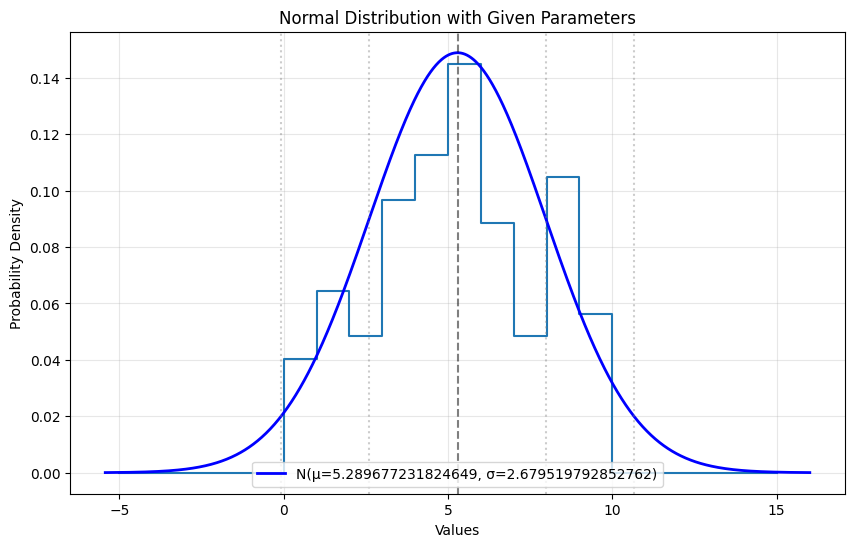

In [702]:
mu = res.x[0]
sigma = res.x[1]

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)

pdf = norm.pdf(x, mu, sigma)
plt.figure(figsize=(10, 6))
plt.step([-5] + [i for i in range(0, 9+1)] + [10, 15], [0] + list(data_df.loc["m_i", :]/max(data_df.loc["m_i", :])*0.145) + [0, 0], where='post')
plt.plot(x, pdf, 'b-', linewidth=2, label=f'N(μ={mu}, σ={sigma})')

plt.title('Normal Distribution with Given Parameters')
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)

# Add vertical line at mean and ±σ intervals
plt.axvline(mu, color='k', linestyle='--', alpha=0.5)
for n in [-2, -1, 1, 2]:
    plt.axvline(mu + n*sigma, color='gray', linestyle=':', alpha=0.4)

In [703]:
p_i_df = pd.DataFrame(columns=columns, index=pd.Index(["p_i"]))
p_i_df.loc["p_i", :] = np.array([round(float(p_m(m, mu, sigma)), ndigits=4) for m in range(0, 9+1)])
p_i_df

,"(-inf, 1)","[1, 2)","[2, 3)","[3, 4)","[4, 5)","[5, 6)","[6, 7)","[7, 8)","[8, 9)","[9, +inf)"
p_i,0.0547,0.0551,0.0866,0.1187,0.1418,0.1476,0.1338,0.1058,0.0728,0.0831


In [704]:
n = 100
np_i_df = pd.DataFrame(columns=columns, index=pd.Index(["np_i"]))
np_i_df.loc["np_i", :] = np.array(p_i_df.loc["p_i", :]*n)
np_i_df

,"(-inf, 1)","[1, 2)","[2, 3)","[3, 4)","[4, 5)","[5, 6)","[6, 7)","[7, 8)","[8, 9)","[9, +inf)"
np_i,5.47,5.51,8.66,11.87,14.18,14.76,13.38,10.58,7.28,8.31


In [705]:
data_df.loc["p_i", :] = np.array([p_i_df.loc["p_i", :]])
data_df.loc["np_i", :] = np.array([np_i_df.loc["np_i", :]])
data_df

,"(-inf, 1)","[1, 2)","[2, 3)","[3, 4)","[4, 5)","[5, 6)","[6, 7)","[7, 8)","[8, 9)","[9, +inf)"
m_i,5,8,6,12,14,18,11,6,13,7
p_i,0.0547,0.0551,0.0866,0.1187,0.1418,0.1476,0.1338,0.1058,0.0728,0.0831
np_i,5.47,5.51,8.66,11.87,14.18,14.76,13.38,10.58,7.28,8.31


#### $n \ge 50;\ n p_i \ge 5\ \ \forall i \in [0, 9] \cap \Z \Rightarrow$ можно применить критерий Пирсона без объединения колонн

## $$\widetilde{\Delta} = \displaystyle\sum_{i=1}^n \frac{(n p_i - m_i)^2}{n p_i}$$

In [706]:
delta = 0
for i in range(0, 9+1): delta += (n*data_df.loc["p_i", columns[i]] - data_df.loc["m_i", columns[i]])**2 / (n*p)
print(f"\u0303\u0394 = {delta}")

̃Δ = 8.511879999999998


# $$p\_value = P(\Delta \ge \widetilde{\Delta}|H_0) = \displaystyle\int_{\widetilde{\Delta}}^{+\infty} q(t)dt$$
# $q(t) = (\chi^2(k-1))'$

In [707]:
sf = chi2.sf(delta, 10-1)
print(f"p-value = {sf}")

p-value = 0.4834936966175828


### p-value $> \alpha \Rightarrow$ Нет оснований отвергуть $H_0$

## Проверка гипотезы с помощью критерия Колмогорова для сложной гипотезы

### $\widetilde{\vec{\theta}}$ - любая состоятельная оценка, полученная доступными методами
### Пусть $\widetilde{\vec{\theta}}$ - оценка, полученная ОМП для нормального распределения
### Т.е. $\widetilde{\theta_1} = \widetilde{\alpha_1}$, $\widetilde{{\theta_2}^2} = \widetilde{\mu_2} = \widetilde{\alpha_2} - \widetilde{\alpha_1}^2$

# $$\widetilde{\Delta} = \sqrt{n}\displaystyle\sup\limits_{x \in \R}|\widetilde{F}(x) - F(x, \widetilde{\vec{\theta}})|$$

Здесь $\widetilde{F}(x)$ - эмпирическая функция распределения

In [708]:
theta_1 = num_data.mean()
theta_2 = num_data.std()

In [709]:
n = 100
columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
index = pd.Index(["m_i", "p_i", "F_empirical_i"])
data_df = pd.DataFrame(columns=columns, index=index)
data_df.loc["m_i", :] = np.array([5, 8, 6, 12, 14, 18, 11, 6, 13, 7])
data_df.loc["p_i", :] = np.array([m_i/n for m_i in data_df.loc["m_i", :]])
data_df.loc["F_empirical_i", :] = np.array([sum(list(data_df.loc["p_i", columns[:i+1]])) for i in range(0, 9+1)])
data_df

,0,1,2,3,4,5,6,7,8,9
m_i,5,8,6,12,14,18,11,6,13,7
p_i,0.05,0.08,0.06,0.12,0.14,0.18,0.11,0.06,0.13,0.07
F_empirical_i,0.05,0.13,0.19,0.31,0.45,0.63,0.74,0.8,0.93,1.0


̃Δ = 1.0133711124224822494840572379347279142842036803577


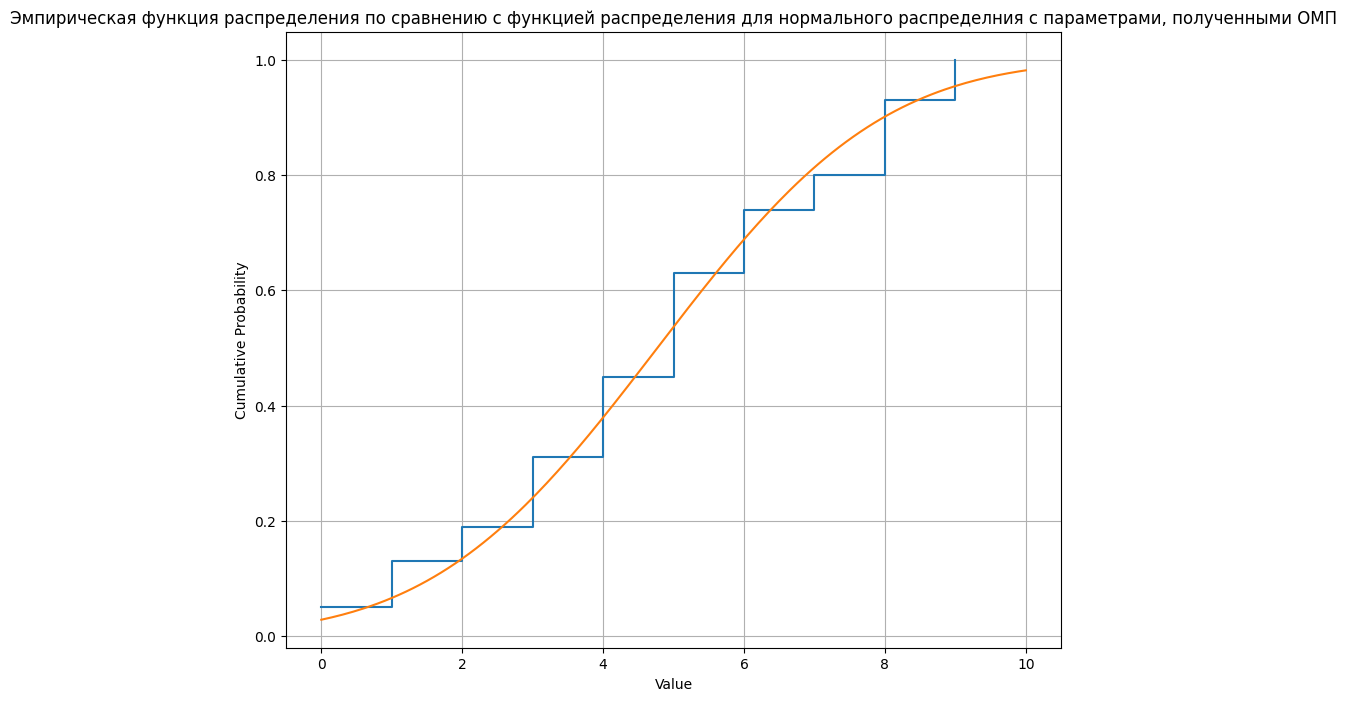

In [710]:
# Эмпирическая функция распределения
plt.step(columns, np.array(data_df.loc["F_empirical_i", :]), where='post')

# Функция распределения нормального распределения
_x = np.array(range(0, 200+1))/20
_y = np.array([normal_F(__x, theta_1, theta_2) for __x in _x])
plt.plot(_x, _y)

delta = 0
delta = max(abs(normal_F(0, theta_1, theta_2) - 0), abs(p_even[0] - p_empirical[0]))
for i in range(1, 9+1):
    delta = max(
        delta,
        abs(normal_F(i, theta_1, theta_2) - data_df.loc["F_empirical_i", i-1]),
        abs(normal_F(i, theta_1, theta_2) - data_df.loc["F_empirical_i", i])
    )
delta *= math.sqrt(n)
print(f"\u0303\u0394 = {delta}")

plt.title('Эмпирическая функция распределения по сравнению с функцией распределения для нормального распределния с параметрами, полученными ОМП')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

## Построение вариационного ряда с помощью параметрического бутстрапа

### 1) $\vec{x_n^*}$ $\rightarrow$ $\widetilde{\vec{\theta}}$ $\rightarrow$ $\Delta_1^*$ = $\sqrt{n}\displaystyle\sup\limits_{x \in \R}|\widetilde{F_{}^*}(x) - F(x, \widetilde{\vec{\theta_{}^*}})|$
### 2) $\vec{x_n^*}$ $\rightarrow$ $\widetilde{\vec{\theta}}$ $\rightarrow$ $\Delta_2^*$ = $\sqrt{n}\displaystyle\sup\limits_{x \in \R}|\widetilde{F_{}^*}(x) - F(x, \widetilde{\vec{\theta_{}^*}})|$
### ...
### N-1) $\vec{x_n^*}$ $\rightarrow$ $\widetilde{\vec{\theta}}$ $\rightarrow$ $\Delta_{N-1}^*$ = $\sqrt{n}\displaystyle\sup\limits_{x \in \R}|\widetilde{F_{}^*}(x) - F(x, \widetilde{\vec{\theta_{}^*}})|$
### N) $\vec{x_n^*}$ $\rightarrow$ $\widetilde{\vec{\theta}}$ $\rightarrow$ $\Delta_N^*$ = $\sqrt{n}\displaystyle\sup\limits_{x \in \R}|\widetilde{F_{}^*}(x) - F(x, \widetilde{\vec{\theta_{}^*}})|$
### Вариационный ряд:
### $\Delta_{(1)}^*$, $\Delta_{(2)}^*$, $\Delta_{(3)}^*$, ... $\Delta_{(N-1)}^*$, $\Delta_{(N)}^*$

In [711]:
def kolmogorov_delta_bootstrap(data: np.array, theta_1: float, theta_2: float, dist) -> float:
    sample = dist.rvs(loc=theta_1, scale=theta_2, size=len(data))
    # Строим эмпирическую функцию распределения
    x = sorted(set(sample))
    sample_dict = dict()
    for value in sample:
        if value in sample_dict:
            sample_dict[value] += 1/len(sample)
        else:
            sample_dict[value] = 1/len(sample)
    F_empirical = [sample_dict[x[0]]]
    for i in range(1, len(x)):
        F_empirical.append(F_empirical[i-1] + sample_dict[x[i]])

    theta_new_1, theta_new_2 = dist.fit(sample)

    new_delta = 0
    new_delta = max(
        abs(dist.cdf(x[0], loc=theta_new_1, scale=theta_new_2) - 0),
        abs(F_empirical[0] - dist.cdf(x[0], loc=theta_new_1, scale=theta_new_2))
        )
    for i in range(1, len(x)):
        new_delta = max(
            new_delta,
            abs(dist.cdf(x[i], loc=theta_new_1, scale=theta_new_2) - F_empirical[i-1]),
            abs(dist.cdf(x[i], loc=theta_new_1, scale=theta_new_2) - F_empirical[i])
            )
    new_delta *= math.sqrt(n)

    return new_delta, theta_new_1, theta_new_2


def parametric_bootstrap_params(data, dist=norm, n_bootstrap=50000) -> tuple:
    original_theta_1, original_theta_2 = dist.fit(data)
    prev_theta_1, prev_theta_2 = original_theta_1, original_theta_2

    deltas = []
    params = [(original_theta_1, original_theta_2)]
    for _ in range(n_bootstrap):
        new_delta, theta_1, theta_2 = kolmogorov_delta_bootstrap(data, original_theta_1, original_theta_2, dist)
        prev_theta_1 = theta_1
        prev_theta_2 = theta_2
        params.append((prev_theta_1, prev_theta_2))
        deltas.append(new_delta)

    return sorted(deltas), params

real_data = [i for i in range(0, 9+1) for _ in range(data_df.loc["m_i", columns[i]])]
deltas, params = parametric_bootstrap_params(np.array(real_data, dtype=np.float32), dist=norm, n_bootstrap=50000)

### p-value = $\frac{k}{N}$, где k - кол-во элементов вариационного ряда $\{\Delta_{(n)}^*\}_1^N$ таких, что $\Delta_{(i)}^* \ge \widetilde{\Delta}$

In [712]:
count = 0
for _delta in deltas:
    if _delta >= delta:
        count += 1
print(f"p_value = {count/len(deltas)}")

p_value = 0.01354


## P-value $\le$ $\alpha$ $\Rightarrow$ отвергаем $H_0$